## Tải dữ liệu

In [1]:
import kagglehub

path = kagglehub.dataset_download("ashishjangra27/face-mask-12k-images-dataset")
print("Path to dataset files:", path)

100%|██████████| 330M/330M [00:03<00:00, 106MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashishjangra27/face-mask-12k-images-dataset/versions/1


## Thư viện

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Xử lý dữ liệu

In [3]:
dataset_path = os.path.join(path, "Face Mask Dataset")
train_dir = os.path.join(dataset_path, "Train")
val_dir = os.path.join(dataset_path, "Validation")
test_dir = os.path.join(dataset_path, "Test")

In [28]:
image_size = (224, 224)
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_size,
                                               batch_size=batch_size,
                                               class_mode='categorical')

val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=image_size,
                                           batch_size=batch_size,
                                           class_mode='categorical')

test_data = val_datagen.flow_from_directory(test_dir,
                                           target_size=image_size,
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                            shuffle=False)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


## Train Model

In [6]:
INIT_LR = 1e-4
EPOCHS = 20

baseModel = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

H = model.fit(
	train_data,
	validation_data=val_data,
	epochs=EPOCHS,
	callbacks=[early_stop])

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 165s 496ms/step - accuracy: 0.8233 - loss: 0.4067 - val_accuracy: 0.9812 - val_loss: 0.0818
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 441ms/step - accuracy: 0.9664 - loss: 0.1104 - val_accuracy: 0.9837 - val_loss: 0.0550
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 432ms/step - accuracy: 0.9717 - loss: 0.0856 - val_accuracy: 0.9887 - val_loss: 0.0417
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 433ms/step - accuracy: 0.9784 - loss: 0.0678 - val_accuracy: 0.9887 - val_loss: 0.0365
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 136s 436ms/step - accuracy: 0.9809 - loss: 0.0645 - val_accuracy: 0.9900 - val_loss: 0.0324
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 431ms/step - accuracy: 0.9805 - loss: 0.0592 - val_accuracy: 0.9912 - val_loss: 0.0288
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 431ms/step - accuracy: 0.9809 - loss: 0.0568 - val_accuracy: 0.9900 - val_loss: 0.0268
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 136s 435ms/step - accuracy: 0.9824 -

## Training Curve

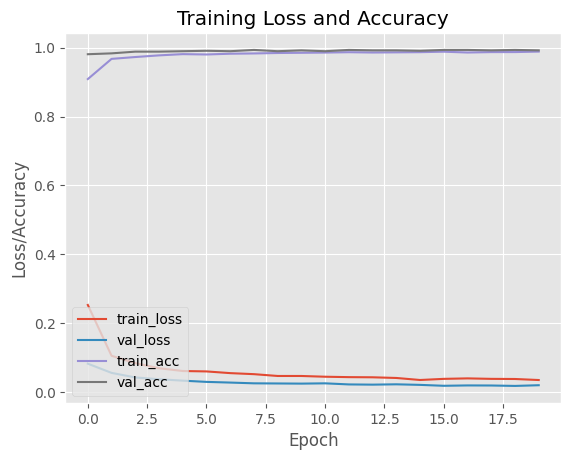

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
N = len(H.history["loss"])

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

## Đánh giá trên tập test

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# Dự đoán trên test set
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

class_labels = list(test_data.class_indices.keys())

# In classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

 1/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
              precision    recall  f1-score   support

    WithMask       0.99      1.00      0.99       483
 WithoutMask       1.00      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



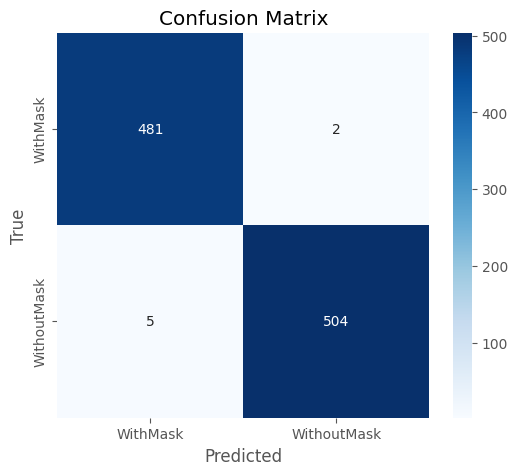

In [30]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [31]:
loss, acc = model.evaluate(test_data)
print(f"Độ chính xác trên tập test: {acc*100:.2f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9958 - loss: 0.0229
Độ chính xác trên tập test: 99.29%


## Lưu model

In [32]:
model.save('model.keras')